# Engineering the target variable

We can always "fix" the target variable in a regression for it to be closer to the assumptions.

For instance, here the `fare` variable is far from a normal distribution, so we might want to rescale it to be closer to normal:

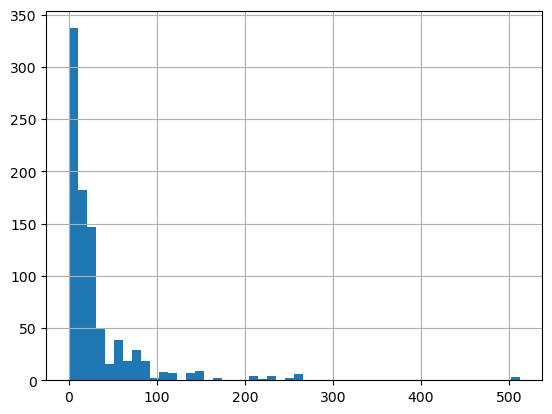

In [1]:
# rescale

import numpy as np
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')
df.fare.hist(bins=50);

ValueError: supplied range of [-inf, 6.238967387173662] is not finite

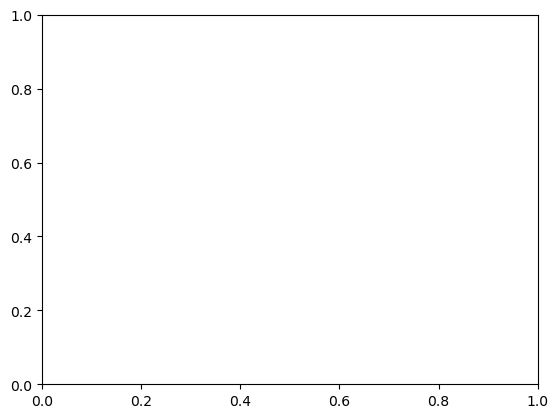

In [3]:
# 
df.fare.apply(np.log).hist(bins=50)

# oops, the logaritm function doesn't support values at 0!
# There are a few solutions to this:

- Use a function that supports it, like `sqrt`. This doesn't flatten an exponential nearly as much though. 
- Use `log(1 + x)` to ensure we're always above 0. This biases the result for smaller values.
- (Recently popular) Use the [inverse hyperbolic sine](https://marcfbellemare.com/wordpress/wp-content/uploads/2019/02/BellemareWichmanIHSFebruary2019.pdf). This is great but is harder to interpret.

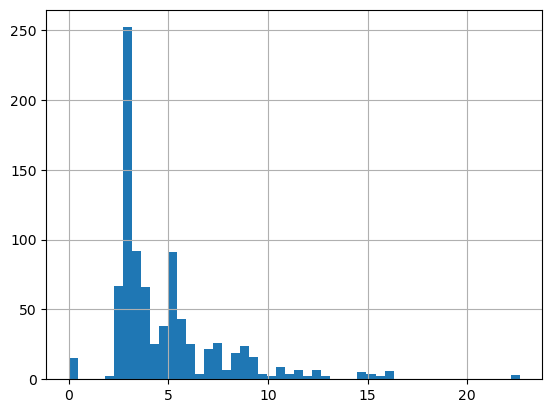

In [4]:
# sqrt

example_1 = df.fare.apply(np.sqrt)
example_1.hist(bins=50);

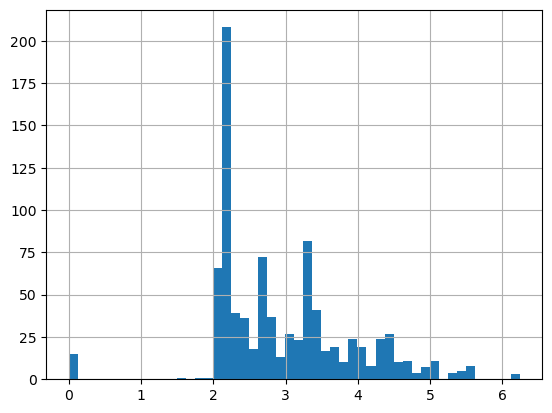

In [5]:
# log

df.fare.apply(lambda X: (np.log(X+1))).hist(bins=50);

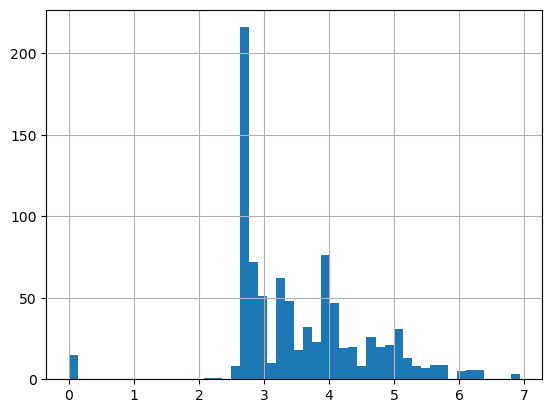

In [6]:
# inverse hyperbolic

df.fare.apply(np.arcsinh).hist(bins=50);

## Interpretation

The interpretation of the coefficients when you modify $y$ is by the inverse of the function you used. So for $ln(y)$ it would be $e^y$, for $arcsinh$ it would be $sinh$, etc.

In [7]:
# example

import statsmodels.api as sm 

df = df.dropna()

y = df.fare.apply(lambda X: (np.log(X + 1)))

dummy = pd.get_dummies(df['class'],drop_first=True)

X = df[['age']].join(dummy)
X = sm.add_constant(X)

est = sm.OLS(y,X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     121.6
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           6.97e-43
Time:                        19:05:01   Log-Likelihood:                -210.31
No. Observations:                 182   AIC:                             428.6
Df Residuals:                     178   BIC:                             441.4
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7276      0.124     38.040      0.000       4.484       4.971
age           -0.0140      0.003     -4.879      0.000      -0.020      -0.008
Second        -1.5130      0.109    -13.895      0.000      -1.726      -1.300
Third         -1.9835      0.112    -17.699      0.000      -2.203      -1.764
==============================================================================
Omnibus:                       84.151   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              624.760
Skew:                          -1.536   Prob(JB):                    2.16e-136
Kurtosis:                      11.541   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

### Rules for interpreting log transform

OK, you ran a regression/fit a linear model and some of your variables are log-transformed.

1. Only the dependent/response variable is log-transformed. Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. 

**Example:** the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9. For every one-unit increase in the independent variable, our dependent variable increases by about 22%.


2. Only independent/predictor variable(s) is log-transformed. Divide the coefficient by 100. This tells us that a 1% increase in the independent variable increases (or decreases) the dependent variable by (coefficient/100) units. 

**Example:** the coefficient is 0.198. 0.198/100 = 0.00198. For every 1% increase in the independent variable, our dependent variable increases by about 0.002. For x percent increase, multiply the coefficient by log(1.x). Example: For every 10% increase in the independent variable, our dependent variable increases by about 0.198 * log(1.10) = 0.02.


3. Both dependent/response variable and independent/predictor variable(s) are log-transformed. Interpret the coefficient as the percent increase in the dependent variable for every 1% increase in the independent variable. 

**Example** the coefficient is 0.198. For every 1% increase in the independent variable, our dependent variable increases by about 0.20%. For x percent increase, calculate 1.x to the power of the coefficient, subtract 1, and multiply by 100. Example: For every 20% increase in the independent variable, our dependent variable increases by about (1.20 0.198 – 1) * 100 = 3.7 percent.

## Linear Probability Model

If we're predicting an outcome which is a boolean, then the outuput of our model is the *percentage probability that y=1*.

Here it is predicting if a passenger was male:

In [8]:
# example

y = (df.sex == 'male').astype(int)

dummy = pd.get_dummies(df['class'],drop_first=True)
X = df[['age']].join(dummy)
X = sm.add_constant(X)

est = sm.OLS(y,X).fit(cov_type='HC2')
est.summary()

# The base probability of being male is 30%.
# The probability of being male given a third class passenger is (30.86 + 6.8) = 37%.
# The probability climbs by 0.5% for each year of age.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sex   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.098
Date:                Tue, 06 Dec 2022   Prob (F-statistic):              0.102
Time:                        19:05:02   Log-Likelihood:                -128.72
No. Observations:                 182   AIC:                             265.4
Df Residuals:                     178   BIC:                             278.3
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3086      0.102      3.028      0.002       0.109       0.508
age            0.0059      0.002      2.391      0.017       0.001       0.011
Second        -0.0567      0.149     -0.382      0.703      -0.348       0.234
Third          0.0683      0.171      0.399      0.690      -0.267       0.404
==============================================================================
Omnibus:                     1176.896   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.052
Skew:                          -0.043   Prob(JB):                     2.20e-06
Kurtosis:                       1.148   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [9]:
est.params

const     0.308638
age       0.005860
Second   -0.056711
Third     0.068293
dtype: float64

In [10]:
df.sex = (df.sex=='male').astype(int)
